# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video. 


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn.functional as F

from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

from torch import nn
import math

from torch.optim import Adam

In [2]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    #grayScaleTransform = transforms.Grayscale()
    plt.figure(figsize=(15,15)) 
    for i, (img,label) in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img)
        #plt.imshow(grayScaleTransform(img[0]),cmap='gray')

data = torchvision.datasets.StanfordCars(root=".", download=False)
#data = torchvision.datasets.StanfordCars(root=".", download=True)

In [3]:
print(type(data))

<class 'torchvision.datasets.stanford_cars.StanfordCars'>


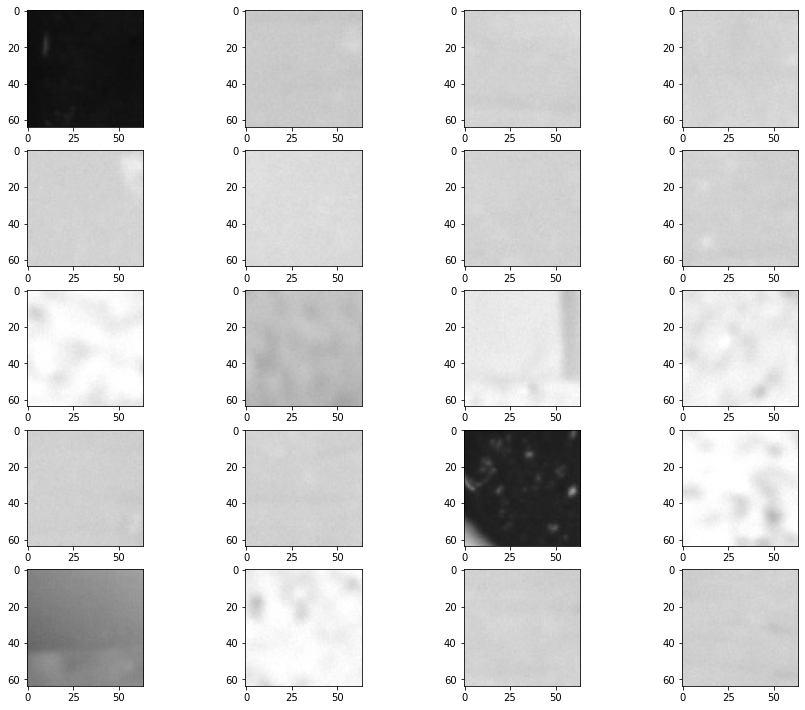

In [4]:
show_images(data)

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect. 

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually. 

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [5]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [6]:
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [7]:
IMG_SIZE = 64
BATCH_SIZE = 64

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
        #transforms.Grayscale() #Dara
    ]
    data_transform = transforms.Compose(data_transforms)     #unsqueeze(0) #Dara

    train = torchvision.datasets.StanfordCars(root=".", download=False, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=".", download=False, 
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
        #transforms.Grayscale() #Dara
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

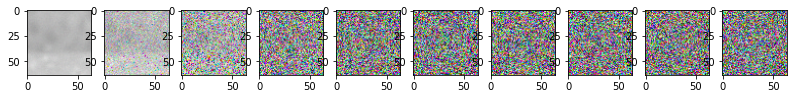

In [8]:
for image,label in dataloader:
    break;
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

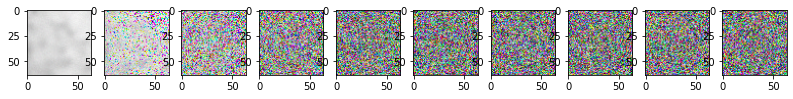

In [9]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, 
                padding_mode='zeros', device=None, dtype=None)

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        out_channels=3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], out_channels, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62433123


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(256,


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [11]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation 
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [12]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    numberOfChannels=3 # Dara
    img = torch.randn((1, numberOfChannels, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images) # 30

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:  #if i is multiple of 30 starting from 270 to 0.
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

## Training

Epoch 0 | step 000 Loss: 0.812233567237854 


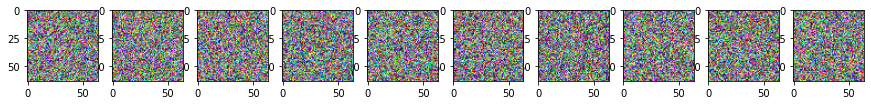

Epoch 5 | step 000 Loss: 0.08992954343557358 


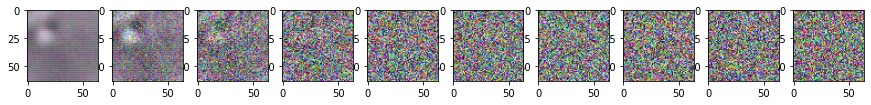

Epoch 10 | step 000 Loss: 0.06545720249414444 


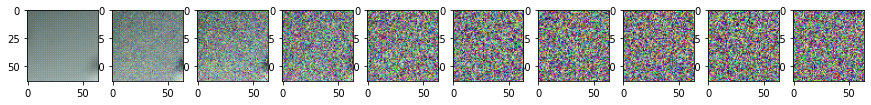

Epoch 15 | step 000 Loss: 0.05386727303266525 


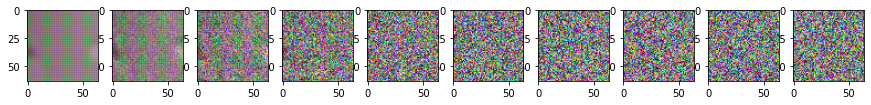

KeyboardInterrupt: 

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.0001) #Dara Changed learning rate
epochs = 60 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()

In Table 2, we show the sample quality effects of reverse process parameterizations and training objectives (Section 3.2). We find that the baseline option of predicting µ˜ works well only when trained on the true variational bound instead of unweighted mean squared error, a simplified objective akin to Eq. (14). We also see that learning reverse process variances (by incorporating a parameterized diagonal Σθ(xt) into the variational bound) leads to unstable training and poorer sample quality compared to fixed variances. Predicting , as we proposed, performs approximately as well as predicting µ˜ when trained on the variational bound with fixed variances, but much better when trained with our simplified objective.

iffusion models scale down the data with each forward process step (by a √ 1 − βt factor) so that variance does not grow when adding noise, thus providing consistently scaled inputs to the neural net reverse process. NCSN omits this scaling factor.

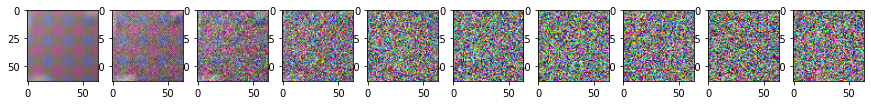

In [14]:
sample_plot_image()

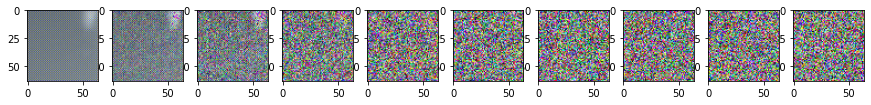

In [15]:
sample_plot_image()

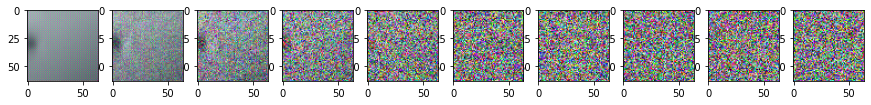

In [16]:
sample_plot_image()

In [19]:
import copy
modelCopy = copy.deepcopy(model)

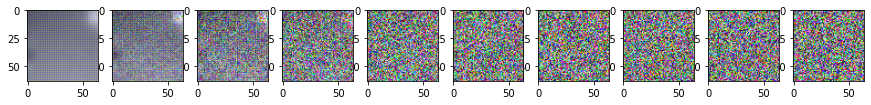

In [20]:
sample_plot_image()

In [21]:
@torch.no_grad()
def sample_timestepC(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * modelCopy(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_imageC():
    # Sample noise
    img_size = IMG_SIZE
    numberOfChannels=3 # Dara
    img = torch.randn((1, numberOfChannels, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images) # 30

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestepC(img, t)
        if i % stepsize == 0:  #if i is multiple of 30 starting from 270 to 0.
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

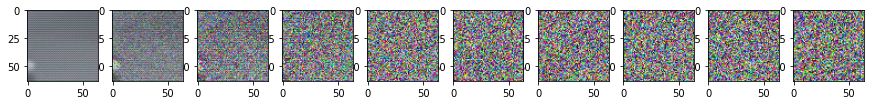

In [22]:
sample_plot_imageC()

In Table 2, we show the sample quality effects of reverse process parameterizations and training
objectives (Section 3.2). We find that the baseline option of predicting µ˜ works well only when
trained on the true variational bound instead of unweighted mean squared error, a simplified objective
akin to Eq. (14). We also see that learning reverse process variances (by incorporating a parameterized
diagonal Σθ(xt) into the variational bound) leads to unstable training and poorer sample quality
compared to fixed variances. Predicting , as we proposed, performs approximately as well as
predicting µ˜ when trained on the variational bound with fixed variances, but much better when trained
with our simplified objective.


iffusion models scale down the data with each forward process step (by a √
1 − βt factor)
so that variance does not grow when adding noise, thus providing consistently scaled inputs
to the neural net reverse process. NCSN omits this scaling factor.


In [23]:
def forwardDiffusionSample_listed(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device),t

In [24]:
for image, label in dataloader:
    break;
    
image=image[0].squeeze()
noisyImageList=[]
timeList=[]
noiseList=[]
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    image, noise,t = forwardDiffusionSample_listed(image, t)
    noisyImageList.append(image)
    timeList.append(t)
    noiseList.append(noise)

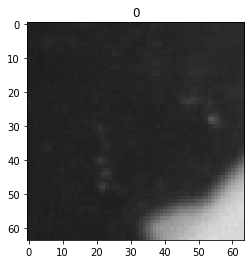

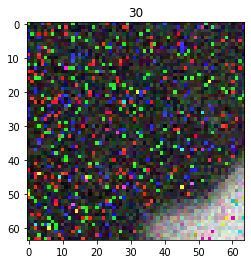

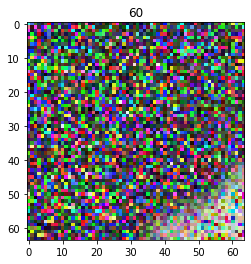

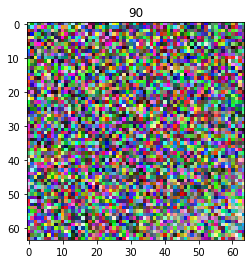

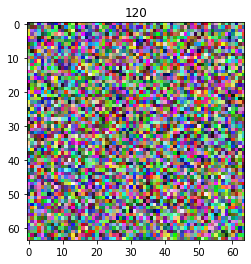

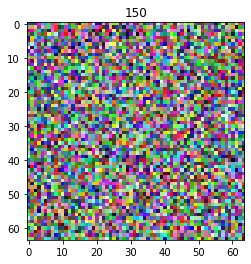

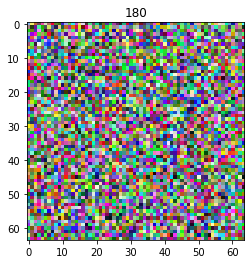

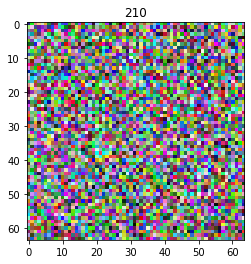

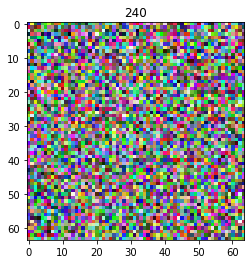

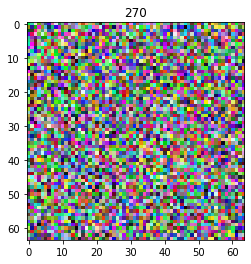

In [26]:
for i in range(len(noisyImageList)):
    show_tensor_image(noisyImageList[i])
    plt.title(str(timeList[i].numpy().item()))
    plt.show()

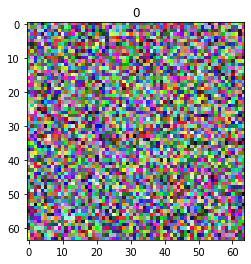

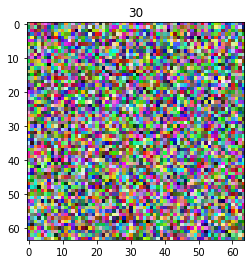

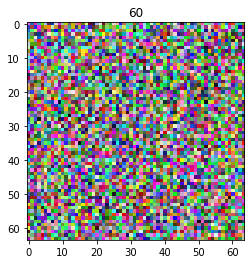

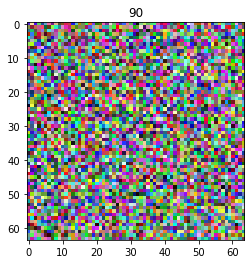

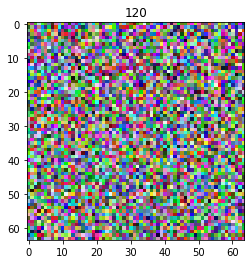

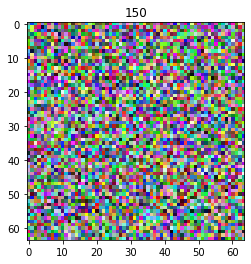

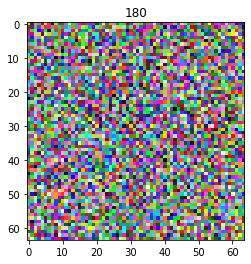

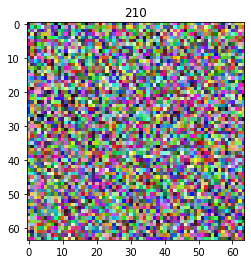

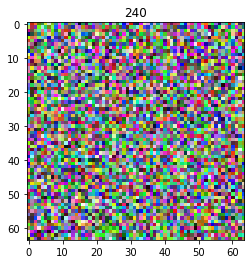

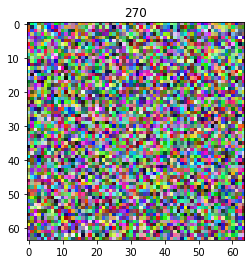

In [27]:
for i in range(len(noisyImageList)):
    show_tensor_image(noiseList[i])
    plt.title(str(timeList[i].numpy().item()))
    plt.show()

In [28]:
timeList_=[tt.cuda() for tt in timeList]
noisyImageList_=[n.unsqueeze(dim=0).cuda() for n in noisyImageList]
noise_=noise.unsqueeze(dim=0).cuda()

In [29]:
model.eval()

for i in range(len(noisyImageList_)):
    with torch.no_grad():
        noise_pred = modelCopy(noisyImageList_[i], timeList_[i])
        print(F.l1_loss(noise_, noise_pred))

tensor(0.9688, device='cuda:0')
tensor(1.1465, device='cuda:0')
tensor(1.1303, device='cuda:0')
tensor(1.1350, device='cuda:0')
tensor(1.1387, device='cuda:0')
tensor(1.1404, device='cuda:0')
tensor(1.1243, device='cuda:0')
tensor(1.1374, device='cuda:0')
tensor(1.1315, device='cuda:0')
tensor(0.2458, device='cuda:0')


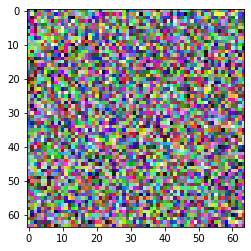

In [32]:
show_tensor_image(noise_pred.cpu())

(-0.5, 63.5, 63.5, -0.5)

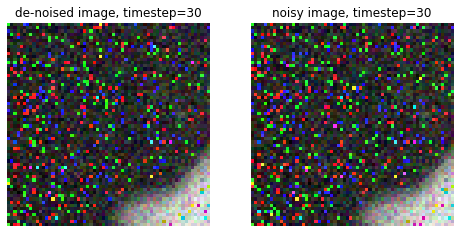

In [50]:
i=1
x=noisyImageList_[i]
t=timeList_[i]
image_=sample_timestepC(x, t)

figure = plt.figure(figsize=(8, 8))
figure.add_subplot(1,2,1)
show_tensor_image(image_.detach().cpu())
plt.title('de-noised image, timestep='+str(t.cpu().numpy().item()))
plt.axis("off")
figure.add_subplot(1,2,2)
show_tensor_image(x.detach().cpu())
plt.title('noisy image, timestep='+str(t.cpu().numpy().item()))
plt.axis("off")

In [71]:
i=2
x=noisyImageList_[i]
t=timeList_[i]
t0=t.clone().detach()

while t>0:
    x=sample_timestepC(x, t)
    t-=t

(-0.5, 63.5, 63.5, -0.5)

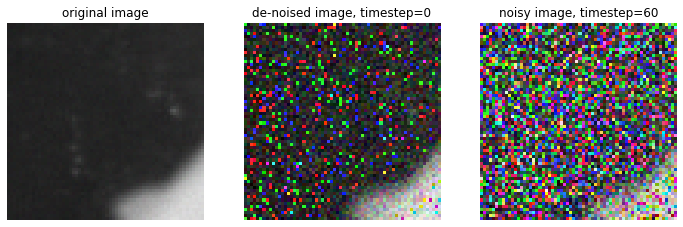

In [74]:
x_0=noisyImageList_[0]

figure = plt.figure(figsize=(12, 8))
figure.add_subplot(1,3,1)
show_tensor_image(x_0.detach().cpu())
plt.title('original image')
plt.axis("off")

figure.add_subplot(1,3,2)
show_tensor_image(image_.detach().cpu())
plt.title('de-noised image, timestep='+str(t.cpu().numpy().item()))
plt.axis("off")

figure.add_subplot(1,3,3)
show_tensor_image(x.detach().cpu())
plt.title('noisy image, timestep='+str(t0.cpu().numpy().item()))
plt.axis("off")

(-0.5, 63.5, 63.5, -0.5)

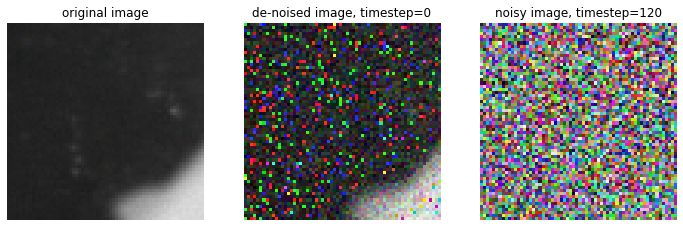

In [75]:
i=4
x=noisyImageList_[i]
t=timeList_[i]
t0=t.clone().detach()

while t>0:
    x=sample_timestepC(x, t)
    t-=t

x_0=noisyImageList_[0]

figure = plt.figure(figsize=(12, 8))
figure.add_subplot(1,3,1)
show_tensor_image(x_0.detach().cpu())
plt.title('original image')
plt.axis("off")

figure.add_subplot(1,3,2)
show_tensor_image(image_.detach().cpu())
plt.title('de-noised image, timestep='+str(t.cpu().numpy().item()))
plt.axis("off")

figure.add_subplot(1,3,3)
show_tensor_image(x.detach().cpu())
plt.title('noisy image, timestep='+str(t0.cpu().numpy().item()))
plt.axis("off")

In [76]:
import os
import shutil
from tqdm.notebook import tqdm as tqdm
from PIL import ImageFont, ImageDraw, Image
from IPython.display import display
from IPython.display import Image as im
import ipyplot
import cv2
%matplotlib inline

In [79]:
directoryName='Dir_GoundTruthRGBForDDPM_Test'
CWD=r"C:\Users\dsi224\Documents\PythonFiles\PythonCodesForDiffusionModel"
directoryPath=os.path.join(CWD, directoryName)

files = os.listdir(directoryPath)
files = [f for f in files if os.path.isfile(directoryPath+'/'+f)]
files = [f for f in files if f.endswith('.jpg')]
len(files)

512

x_0_y_0_.jpg
(64, 64, 3)


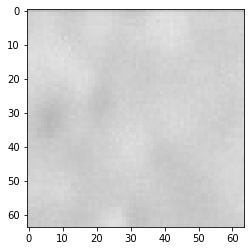

In [132]:
image_name=files[0]
print(image_name)
imageFullName=os.path.join(directoryPath, image_name)
image = (cv2.imread(imageFullName, cv2.IMREAD_COLOR))/255.0
print(image.shape)
plt.imshow(image)
plt.show()

In [133]:
tt=transforms.ToTensor()
image_=tt(image).unsqueeze(dim=0)

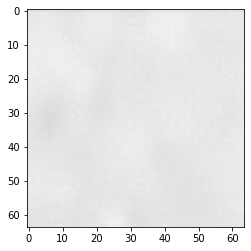

In [134]:
show_tensor_image(image_)

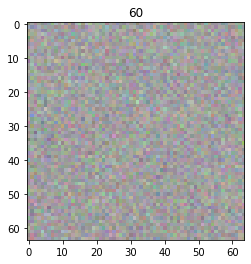

In [135]:
idx=60
t = torch.Tensor([idx]).type(torch.int64)
image__, noise_,t_ = forwardDiffusionSample_listed(image_, t)
image__=image__/3.0
show_tensor_image(image__)
plt.title(str(t_.numpy().item()))
plt.show()

In [136]:
image__.max()

tensor(0.7070, dtype=torch.float64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


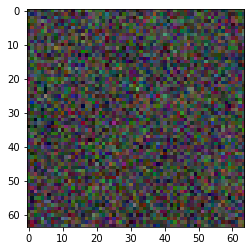

In [137]:
image___=np.transpose(image__.squeeze().numpy(),(1,2,0))
plt.imshow(image___)

In [131]:
np.max(image___)

0.6887506589024021

(-0.5, 63.5, 63.5, -0.5)

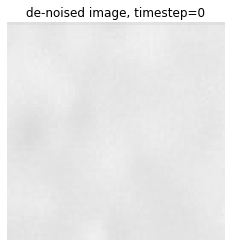

In [108]:
x=image__.to(torch.float32).cuda()
t=t.cuda()
while t>0:
    x=sample_timestepC(x, t)
    t-=t
show_tensor_image(image_.detach().cpu())
plt.title('de-noised image, timestep='+str(t.cpu().numpy().item()))
plt.axis("off")

In [109]:
files = os.listdir(directoryPath)
files = [f for f in files if os.path.isfile(directoryPath+'/'+f)]
files = [f for f in files if f.endswith('.jpg')]
len(files)

512

In [154]:
emptyImage_ForNoisyImage=np.zeros((2048, 1024, 3))
emptyImage.shape

(2048, 1024, 3)

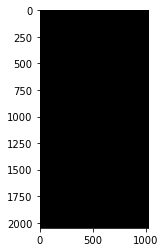

In [155]:
plt.imshow(emptyImage_ForNoisyImage);

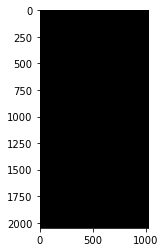

In [156]:
emptyImage_ForDenoisedImage=np.zeros((2048, 1024, 3))
plt.imshow(emptyImage_ForDenoisedImage);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


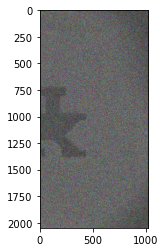

In [157]:
tt=transforms.ToTensor()
idx=270
t = torch.Tensor([idx]).type(torch.int64)


for image_name in files:
    imageFullName=os.path.join(directoryPath, image_name)
    image = (cv2.imread(imageFullName, cv2.IMREAD_COLOR))/255.0
    image_=tt(image).unsqueeze(dim=0)
    image__, noise_,t_ = forwardDiffusionSample_listed(image_, t)
    image___=np.transpose(image__.squeeze().numpy(),(1,2,0))
    
    split=image_name.split("_")
    x=int(split[1])
    y=int(split[3])
    
    emptyImage_ForNoisyImage[x:x+64,y:y+64]=image___
plt.imshow(emptyImage_ForNoisyImage);
plt.show()

In [158]:
emptyImage_ForNoisyImage.max()

5.121635584988628

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


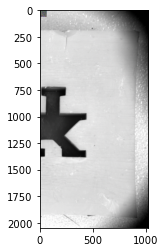

In [159]:
tt=transforms.ToTensor()
idx=270
t = torch.Tensor([idx]).type(torch.int64)


for image_name in files:
    imageFullName=os.path.join(directoryPath, image_name)
    image = (cv2.imread(imageFullName, cv2.IMREAD_COLOR))/255.0
    image_=tt(image).unsqueeze(dim=0)
    image__, noise_,t_ = forwardDiffusionSample_listed(image_, t)
    #image___=np.transpose(image__.squeeze().numpy(),(1,2,0))
    
    x=image__.to(torch.float32).cuda()
    t=t.cuda()
    while t>0:
        x=sample_timestepC(x, t)
        t-=t
    image___=np.transpose(x.squeeze().cpu().numpy(),(1,2,0))
    
    split=image_name.split("_")
    x=int(split[1])
    y=int(split[3])
    
    emptyImage_ForDenoisedImage[x:x+64,y:y+64]=image___
plt.imshow(emptyImage_ForDenoisedImage);
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1023.5, 2047.5, -0.5)

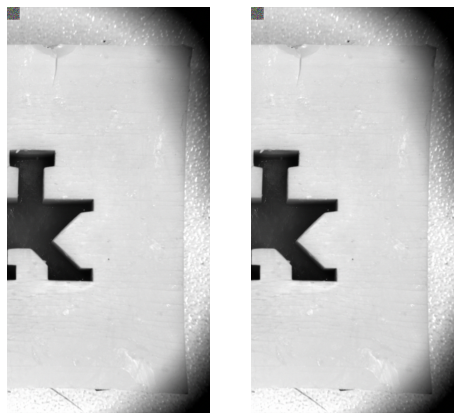

In [169]:
tt=transforms.ToTensor()
idx=270
t = torch.Tensor([idx]).type(torch.int64)
emptyImage_ForNoisyImage=np.zeros((2048, 1024, 3))
emptyImage_ForDenoisedImage=np.zeros((2048, 1024, 3))

for image_name in files:
    imageFullName=os.path.join(directoryPath, image_name)
    image = (cv2.imread(imageFullName, cv2.IMREAD_COLOR))/255.0
    image_=tt(image).unsqueeze(dim=0)
    image__, noise_,t_ = forwardDiffusionSample_listed(image_, t)
    image___=np.transpose(image__.squeeze().numpy(),(1,2,0))
    
    split=image_name.split("_")
    x=int(split[1])
    y=int(split[3])
    
    emptyImage_ForNoisyImage[x:x+64,y:y+64]=image___
    
    
    X=image__.to(torch.float32).cuda()
    t=t.cuda()
    while t>0:
        X=sample_timestepC(X, t)
        t-=t
    image____=np.transpose(X.squeeze().cpu().numpy(),(1,2,0))
    
    

    emptyImage_ForDenoisedImage[x:x+64,y:y+64]=image____
    
figure = plt.figure(figsize=(8, 8))

figure.add_subplot(1,2,1)
plt.imshow(emptyImage_ForNoisyImage);

plt.axis('off')

figure.add_subplot(1,2,2)
plt.imshow(emptyImage_ForDenoisedImage);
plt.axis('off')

In [171]:
torch.cuda.get_device_name(0)

'Quadro P2200'